In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

In [54]:
def plot_2d_points(X, labels=None, centers=None, title=None):
    # Рисует 2D-точки.
    # - X: массив формы (n_samples, 2)
    # - labels: метки кластеров (если есть)
    # - centers: центры кластеров (если есть)
    if X.shape[1] != 2:
        raise ValueError("plot_2d_points ожидает X с двумя признаками (n_samples, 2).")

    plt.figure(figsize=(7, 5))
    if labels is None:
        plt.scatter(X[:, 0], X[:, 1], s=25)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=25)

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker="X", s=220, edgecolor="k")

    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True, alpha=0.25)
    plt.show()


def evaluate_k_range(X, k_values, scale=False, random_state=42):
    # Для заданных K считает:
    # - inertia_ (ниже лучше)
    # - silhouette_score (выше лучше; определён для K>=2)
    #
    # Возвращает словарь с массивами метрик.
    X_work = X
    if scale:
        scaler = StandardScaler()
        X_work = scaler.fit_transform(X_work)

    inertias = []
    silhouettes = []

    for k in k_values:
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = model.fit_predict(X_work)

        inertias.append(model.inertia_)
        # silhouette определён только если кластеров >= 2 и есть хотя бы 2 разных кластера
        if k >= 2 and len(np.unique(labels)) > 1:
            silhouettes.append(silhouette_score(X_work, labels))
        else:
            silhouettes.append(np.nan)

    return {
        "k": np.array(list(k_values), dtype=int),
        "inertia": np.array(inertias, dtype=float),
        "silhouette": np.array(silhouettes, dtype=float),
        "scaled": bool(scale),
    }


def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()


def plot_points(X, title="", ax=None):
    """Базовый scatter для 2D-точек."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(X[:, 0], X[:, 1], s=20)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    return ax

def plot_dbscan(X, labels, title="", ax=None):
    """Визуализация результата DBSCAN: кластеры + шум."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    labels = np.asarray(labels)
    unique = sorted(set(labels))

    for lab in unique:
        mask = labels == lab
        if lab == -1:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, marker="x", label="noise (-1)")
        else:
            ax.scatter(X[mask, 0], X[mask, 1], s=20, label=f"cluster {lab}")

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")
    return ax

def summarize_labels(labels):
    """Короткая статистика по разметке: число кластеров, доля шума."""
    labels = np.asarray(labels)
    n_noise = np.sum(labels == -1)
    n_points = len(labels)
    clusters = sorted([c for c in set(labels) if c != -1])
    return {
        "n_points": n_points,
        "n_clusters": len(clusters),
        "n_noise": int(n_noise),
        "noise_share": float(n_noise / n_points)
    }

def safe_internal_metrics(X, labels):
    """Внутренние метрики для кластеров.

    Важно:
    - silhouette корректно считать, когда есть >=2 кластера.
    - шум (-1) лучше исключать из расчёта, иначе метрика становится трудно интерпретируемой.
    """
    labels = np.asarray(labels)
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]

    result = {}

    # если осталось меньше 2 кластеров – метрики бессмысленны
    if len(set(y2)) < 2:
        result["silhouette"] = None
        result["calinski_harabasz"] = None
        result["davies_bouldin"] = None
        return result

    result["silhouette"] = float(silhouette_score(X2, y2))
    result["calinski_harabasz"] = float(calinski_harabasz_score(X2, y2))
    result["davies_bouldin"] = float(davies_bouldin_score(X2, y2))
    return result


def plot_pca_2d(X, labels, title):
    """Простая 2D-визуализация кластеров через PCA."""
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(7, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=35)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.25)
    plt.show()

def cluster_sizes(labels):
    """Размеры кластеров (сколько точек в каждом)."""
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def create_preprocessing_pipeline(df, dataset_name):
    # Удаляем sample_id, так как это идентификатор
    features = [col for col in df.columns if col != 'sample_id']
    
    
    has_missing = df[features].isnull().any().any()
    
    
    numeric_features = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median' if has_missing else 'constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='drop'  
    )
    
    # Полный пайплайн
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    
    
    
    return pipeline, numeric_features

def apply_preprocessing(pipeline, df, dataset_name):
    
    # Удаляем sample_id
    X = df.drop('sample_id', axis=1) if 'sample_id' in df.columns else df
    
    
    X_processed = pipeline.fit_transform(X)
    
    
    
    return X_processed

def save_preprocessing_plots(df_before, X_after, dataset_name, features, save_dir=figures_dir):
    """
    Создает и сохраняет графики для визуализации препроцессинга.
    """
    print(f"\nСоздание графиков для {dataset_name}...")
    
    # 1. Гистограммы распределений (первые 4 признака)
    n_features_to_show = min(4, len(features))
    
    fig1, axes1 = plt.subplots(n_features_to_show, 2, figsize=(12, 3 * n_features_to_show))
    
    if n_features_to_show == 1:
        axes1 = axes1.reshape(1, -1)
    
    for i in range(n_features_to_show):
        # До препроцессинга
        ax1 = axes1[i, 0] if n_features_to_show > 1 else axes1[0, 0]
        col_name = features[i]
        data_before = df_before[col_name]
        
        ax1.hist(data_before, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title(f'{col_name} - До препроцессинга')
        ax1.set_xlabel('Значение')
        ax1.set_ylabel('Частота')
        ax1.grid(True, alpha=0.3)
        
        # После препроцессинга
        ax2 = axes1[i, 1] if n_features_to_show > 1 else axes1[0, 1]
        data_after = X_after[:, i]
        ax2.hist(data_after, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        ax2.set_title(f'{col_name} - После препроцессинга')
        ax2.set_xlabel('Значение')
        ax2.set_ylabel('Частота')
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Распределения признаков: {dataset_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    
    # Сохраняем гистограммы
    hist_filename = save_dir / f"{dataset_name}_distributions.png"
    plt.savefig(hist_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Сохранено: {hist_filename}")
    
    # 2. Box plots для сравнения масштабов
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
    
    # До препроцессинга (первые 4 признака)
    data_before_df = df_before[features[:4]]
    
    box1 = axes2[0].boxplot([data_before_df.iloc[:, i] for i in range(data_before_df.shape[1])],
                           patch_artist=True)  # Добавляем patch_artist=True
    axes2[0].set_title(f'Масштабы признаков ДО препроцессинга\n{dataset_name}')
    axes2[0].set_xlabel('Признаки')
    axes2[0].set_ylabel('Значения')
    axes2[0].set_xticks(range(1, data_before_df.shape[1] + 1))
    axes2[0].set_xticklabels(data_before_df.columns[:4], rotation=45)
    axes2[0].grid(True, alpha=0.3)
    
    # После препроцессинга
    n_features_vis = min(4, X_after.shape[1])
    box2 = axes2[1].boxplot([X_after[:, i] for i in range(n_features_vis)],
                           patch_artist=True)  # Добавляем patch_artist=True
    axes2[1].set_title(f'Масштабы признаков ПОСЛЕ препроцессинга\n{dataset_name}')
    axes2[1].set_xlabel('Признаки')
    axes2[1].set_ylabel('Значения')
    axes2[1].set_xticks(range(1, n_features_vis + 1))
    axes2[1].set_xticklabels([f'{features[i]}' for i in range(n_features_vis)], rotation=45)
    axes2[1].grid(True, alpha=0.3)
    
    # Правильно задаем цвета для box plots
    for box in box1['boxes']:
        box.set_facecolor('lightblue')
        box.set_edgecolor('blue')
        box.set_linewidth(1.5)
        box.set_alpha(0.7)
    
    for box in box2['boxes']:
        box.set_facecolor('lightcoral')
        box.set_edgecolor('red')
        box.set_linewidth(1.5)
        box.set_alpha(0.7)
    
    plt.tight_layout()
    
    # Сохраняем box plots
    boxplot_filename = save_dir / f"{dataset_name}_scales_comparison.png"
    plt.savefig(boxplot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Сохранено: {boxplot_filename}")
    
    # 3. Scatter plot для 2D данных (если есть 2 или более признаков)
    if X_after.shape[1] >= 2:
        fig3, axes3 = plt.subplots(1, 2, figsize=(12, 5))
        
        # До препроцессинга (первые 2 признака)
        axes3[0].scatter(df_before[features[0]], df_before[features[1]], 
                        alpha=0.5, s=10, color='blue')
        axes3[0].set_title(f'До препроцессинга: {features[0]} vs {features[1]}')
        axes3[0].set_xlabel(features[0])
        axes3[0].set_ylabel(features[1])
        axes3[0].grid(True, alpha=0.3)
        
        # После препроцессинга
        axes3[1].scatter(X_after[:, 0], X_after[:, 1], 
                        alpha=0.5, s=10, color='red')
        axes3[1].set_title(f'После препроцессинга: {features[0]} vs {features[1]}')
        axes3[1].set_xlabel(f'{features[0]} (стандартизовано)')
        axes3[1].set_ylabel(f'{features[1]} (стандартизовано)')
        axes3[1].grid(True, alpha=0.3)
        
        plt.suptitle(f'Scatter plot для {dataset_name}', fontsize=14, y=1.02)
        plt.tight_layout()
        
        # Сохраняем scatter plot
        scatter_filename = save_dir / f"{dataset_name}_scatter_comparison.png"
        plt.savefig(scatter_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Сохранено: {scatter_filename}")
    
    # 4. Статистика распределений (текстовый вывод)
    print(f"\nСтатистика для {dataset_name}:")
    print("-" * 40)
    
    for i, feature in enumerate(features[:3]):  # Первые 3 признака
        before_mean = df_before[feature].mean()
        before_std = df_before[feature].std()
        
        if i < X_after.shape[1]:
            after_mean = X_after[:, i].mean()
            after_std = X_after[:, i].std()
            
            print(f"{feature}:")
            print(f"  До: mean={before_mean:.2f}, std={before_std:.2f}")
            print(f"  После: mean={after_mean:.2f}, std={after_std:.2f}")
            print()

In [37]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [38]:
df1 = pd.read_csv('data/S07-hw-dataset-01.csv')
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')
df3 = pd.read_csv('data/S07-hw-dataset-03.csv')
artifacts_dir = Path("artifacts")
figures_dir = artifacts_dir / "figures"

In [39]:
df1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [40]:
df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [41]:
df3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [44]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [45]:
df1.isna().sum().sum()

np.int64(0)

In [46]:
df2.isna().sum().sum()

np.int64(0)

In [47]:
df3.isna().sum().sum()

np.int64(0)

In [48]:
# Создаем и применяем препроцессинг для каждого датасета
preprocessing_results = {}

# Для dataset01
pipeline01, features01 = create_preprocessing_pipeline(df1, "dataset01")
X1_processed = apply_preprocessing(pipeline01, df1, "dataset01")
preprocessing_results['dataset01'] = {
    'pipeline': pipeline01,
    'features': features01,
    'X_processed': X1_processed,
    'original_shape': df1.shape,
    'processed_shape': X1_processed.shape
}

# Для dataset02
pipeline02, features02 = create_preprocessing_pipeline(df2, "dataset02")
X2_processed = apply_preprocessing(pipeline02, df2, "dataset02")
preprocessing_results['dataset02'] = {
    'pipeline': pipeline02,
    'features': features02,
    'X_processed': X2_processed,
    'original_shape': df2.shape,
    'processed_shape': X2_processed.shape
}

# Для dataset03
pipeline03, features03 = create_preprocessing_pipeline(df3, "dataset03")
X3_processed = apply_preprocessing(pipeline03, df3, "dataset03")
preprocessing_results['dataset03'] = {
    'pipeline': pipeline03,
    'features': features03,
    'X_processed': X3_processed,
    'original_shape': df3.shape,
    'processed_shape': X3_processed.shape
}

Создан препроцессинг для dataset01:
  - Признаки: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']
  - Пропуски: нет
  - Стратегия обработки пропусков: none
Препроцессинг для dataset01:
  - Исходная форма: (12000, 8)
  - После обработки: (12000, 8)
Создан препроцессинг для dataset02:
  - Признаки: ['x1', 'x2', 'z_noise']
  - Пропуски: нет
  - Стратегия обработки пропусков: none
Препроцессинг для dataset02:
  - Исходная форма: (8000, 3)
  - После обработки: (8000, 3)
Создан препроцессинг для dataset03:
  - Признаки: ['x1', 'x2', 'f_corr', 'f_noise']
  - Пропуски: нет
  - Стратегия обработки пропусков: none
Препроцессинг для dataset03:
  - Исходная форма: (15000, 4)
  - После обработки: (15000, 4)


In [49]:
preprocessing_results

{'dataset01': {'pipeline': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(fill_value=0,
                                                                                   strategy='constant')),
                                                                    ('scaler',
                                                                     StandardScaler())]),
                                                    ['f01', 'f02', 'f03', 'f04',
                                                     'f05', 'f06', 'f07',
                                                     'f08'])]))]),
  'features': ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08'],
  'X_processed': array([[ 0.17142668, -1.46280499,  0.43827875, ..., -0.89591542,
          -0.11539556, -0.84301268],
         [ 1.603


Создание графиков для dataset01...


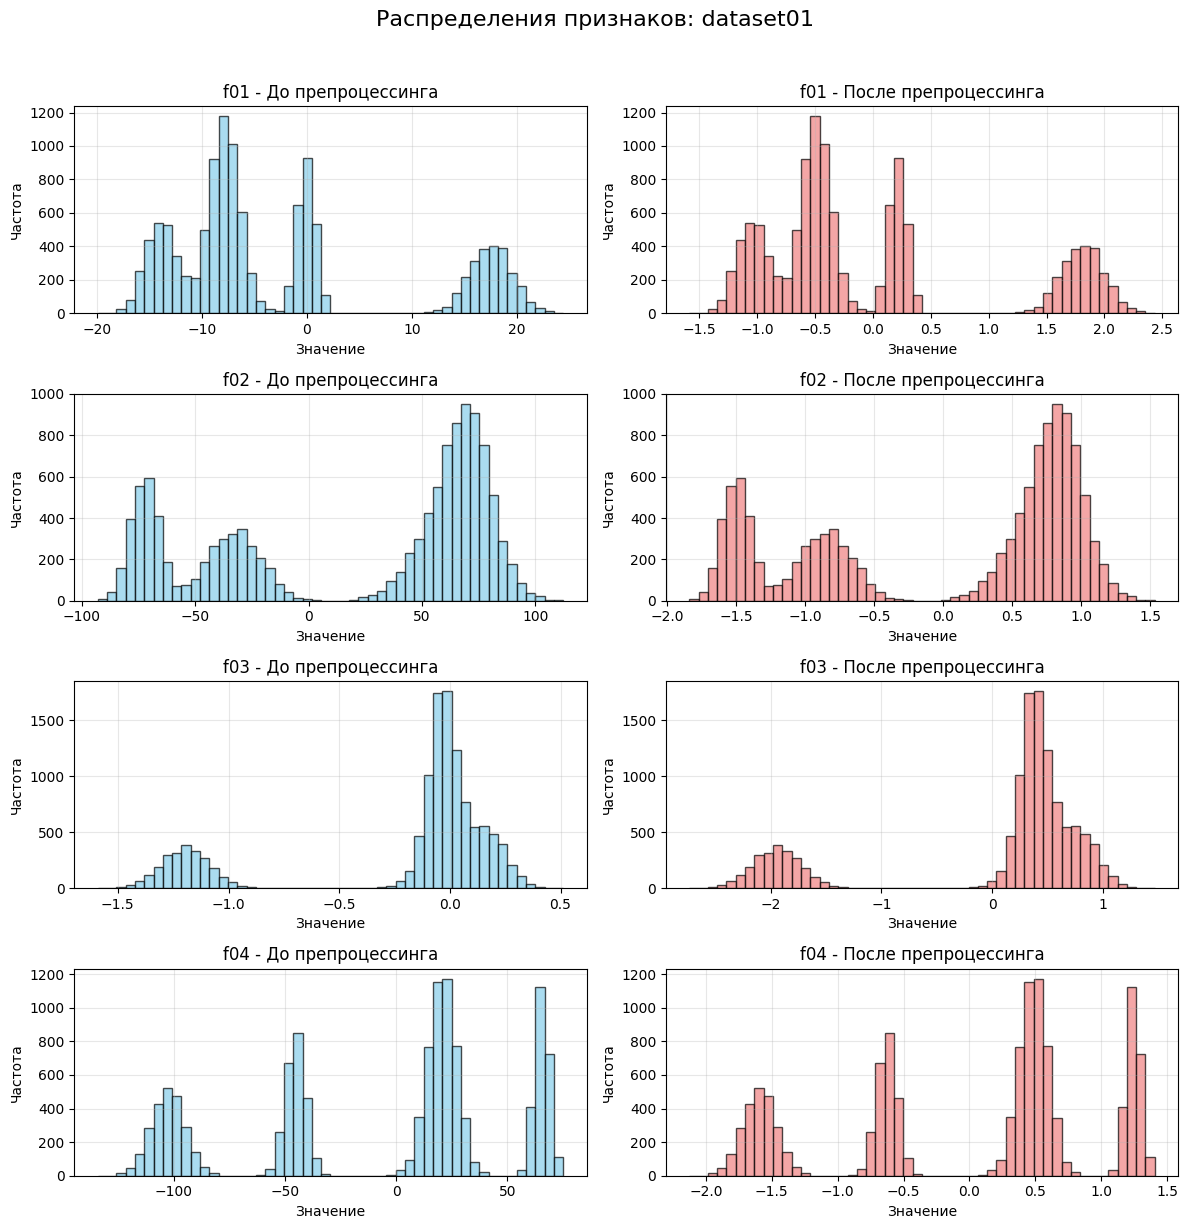

Сохранено: artifacts\figures\dataset01_distributions.png


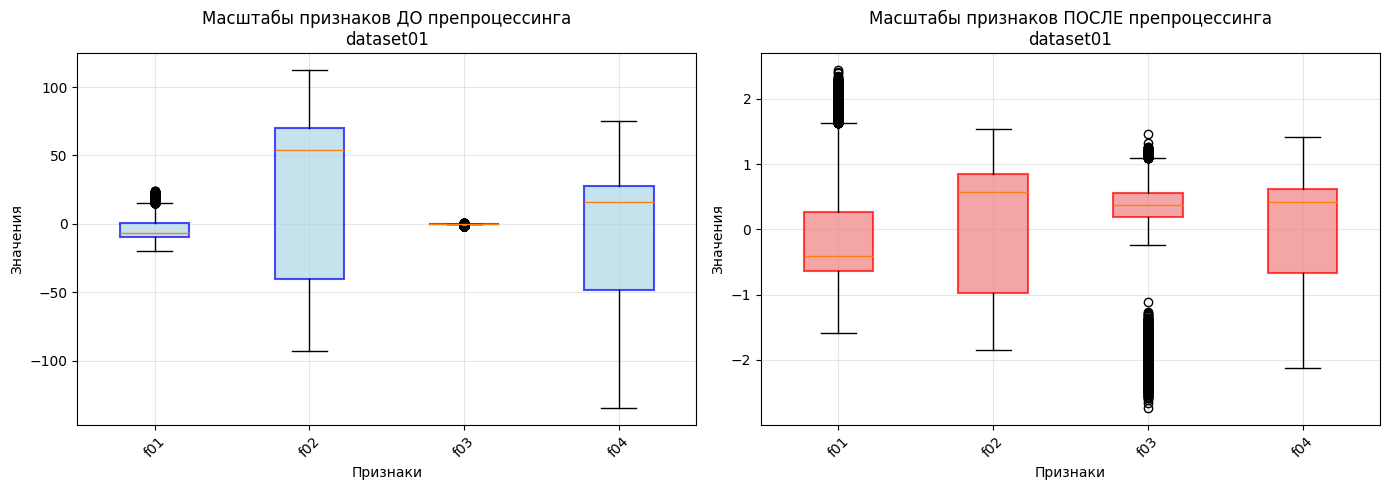

Сохранено: artifacts\figures\dataset01_scales_comparison.png


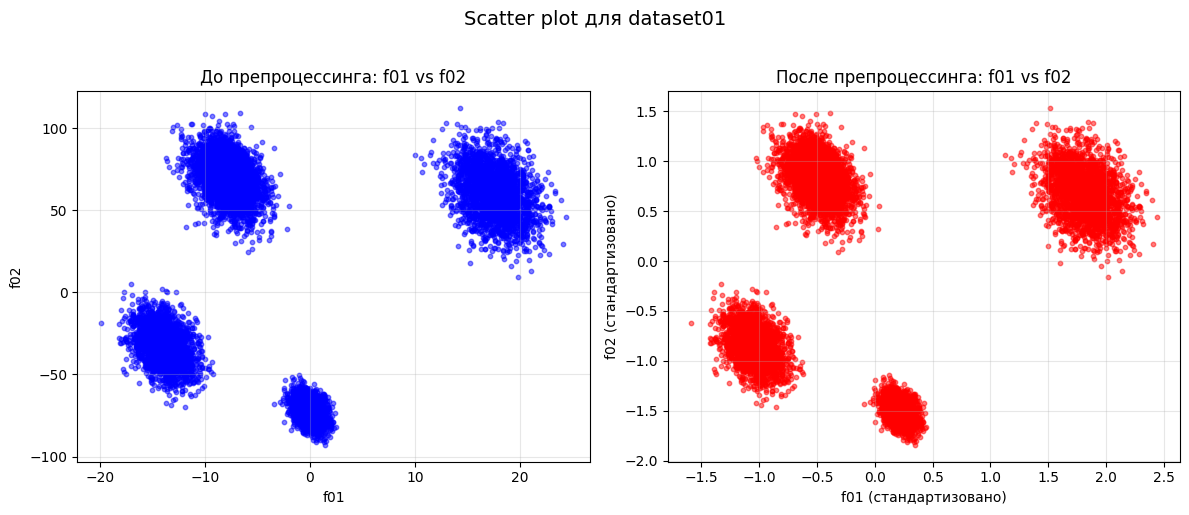

Сохранено: artifacts\figures\dataset01_scatter_comparison.png

Статистика для dataset01:
----------------------------------------
f01:
  До: mean=-2.42, std=11.01
  После: mean=0.00, std=1.00

f02:
  До: mean=19.11, std=60.79
  После: mean=-0.00, std=1.00

f03:
  До: mean=-0.22, std=0.50
  После: mean=-0.00, std=1.00


Создание графиков для dataset02...


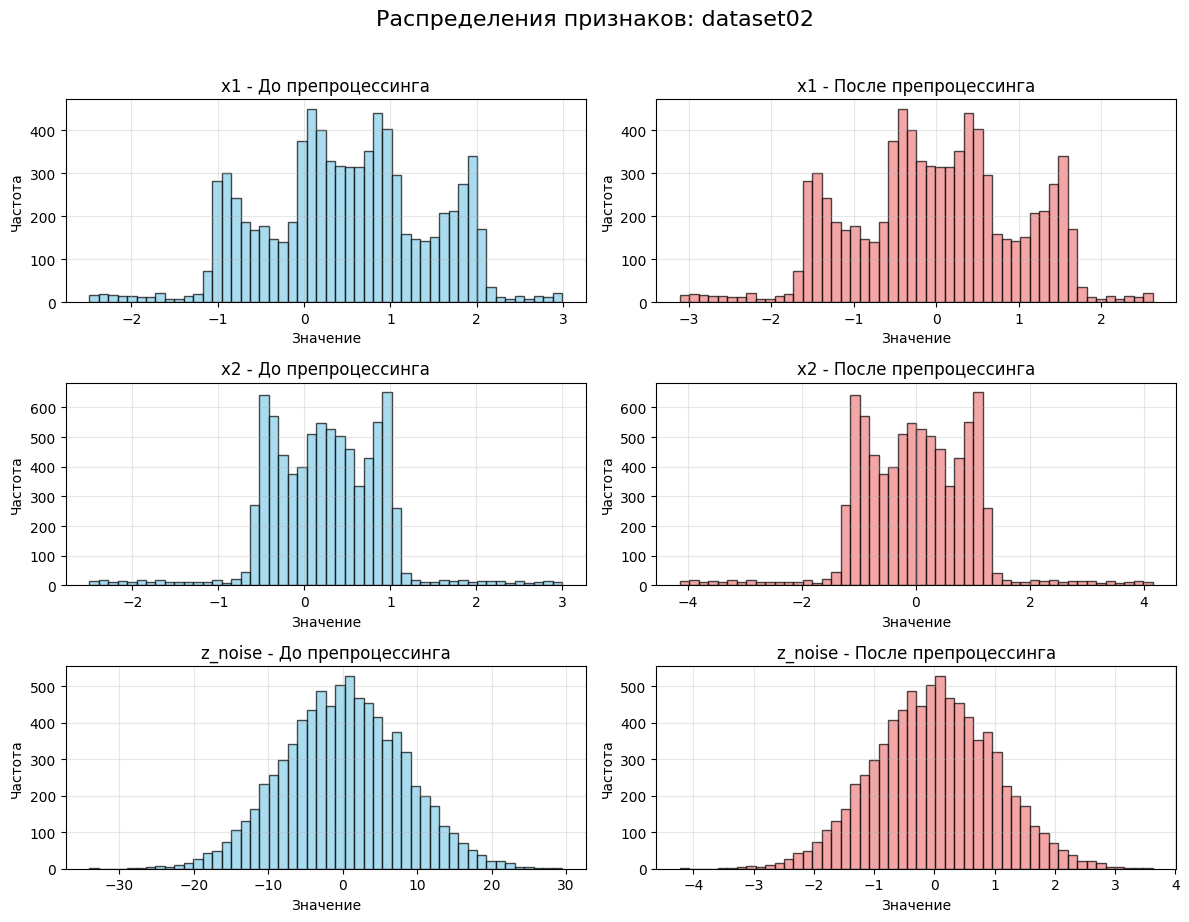

Сохранено: artifacts\figures\dataset02_distributions.png


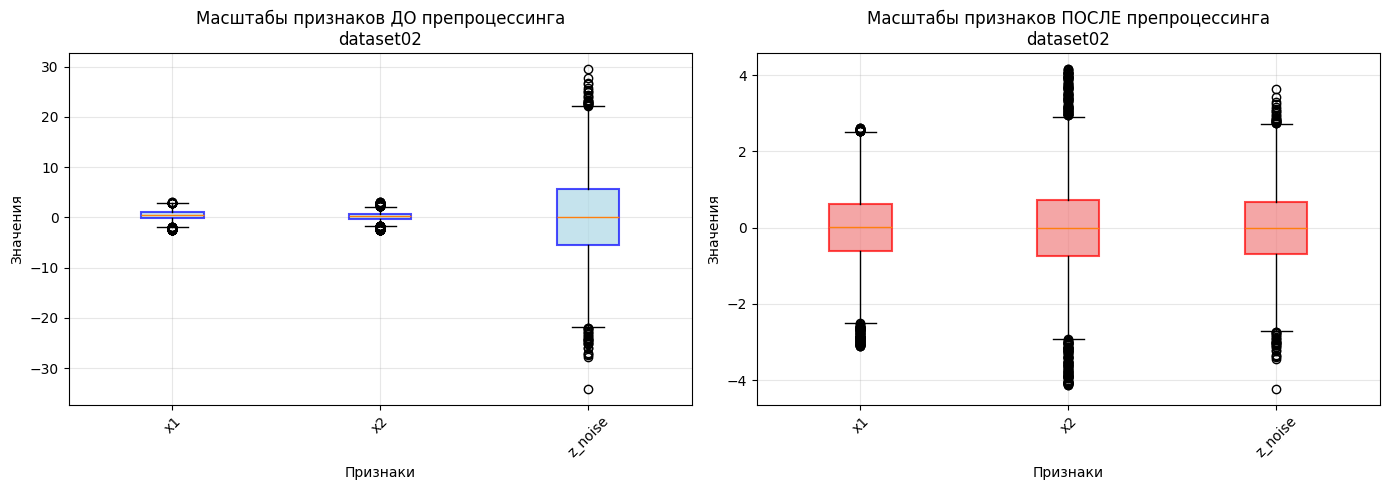

Сохранено: artifacts\figures\dataset02_scales_comparison.png


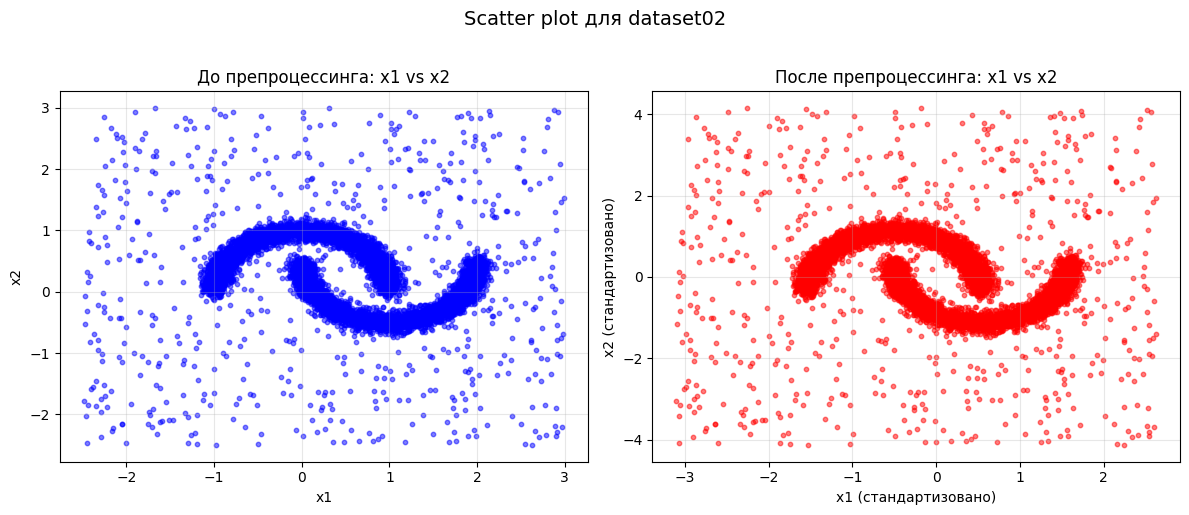

Сохранено: artifacts\figures\dataset02_scatter_comparison.png

Статистика для dataset02:
----------------------------------------
x1:
  До: mean=0.48, std=0.96
  После: mean=-0.00, std=1.00

x2:
  До: mean=0.24, std=0.66
  После: mean=0.00, std=1.00

z_noise:
  До: mean=0.11, std=8.10
  После: mean=-0.00, std=1.00


Создание графиков для dataset03...


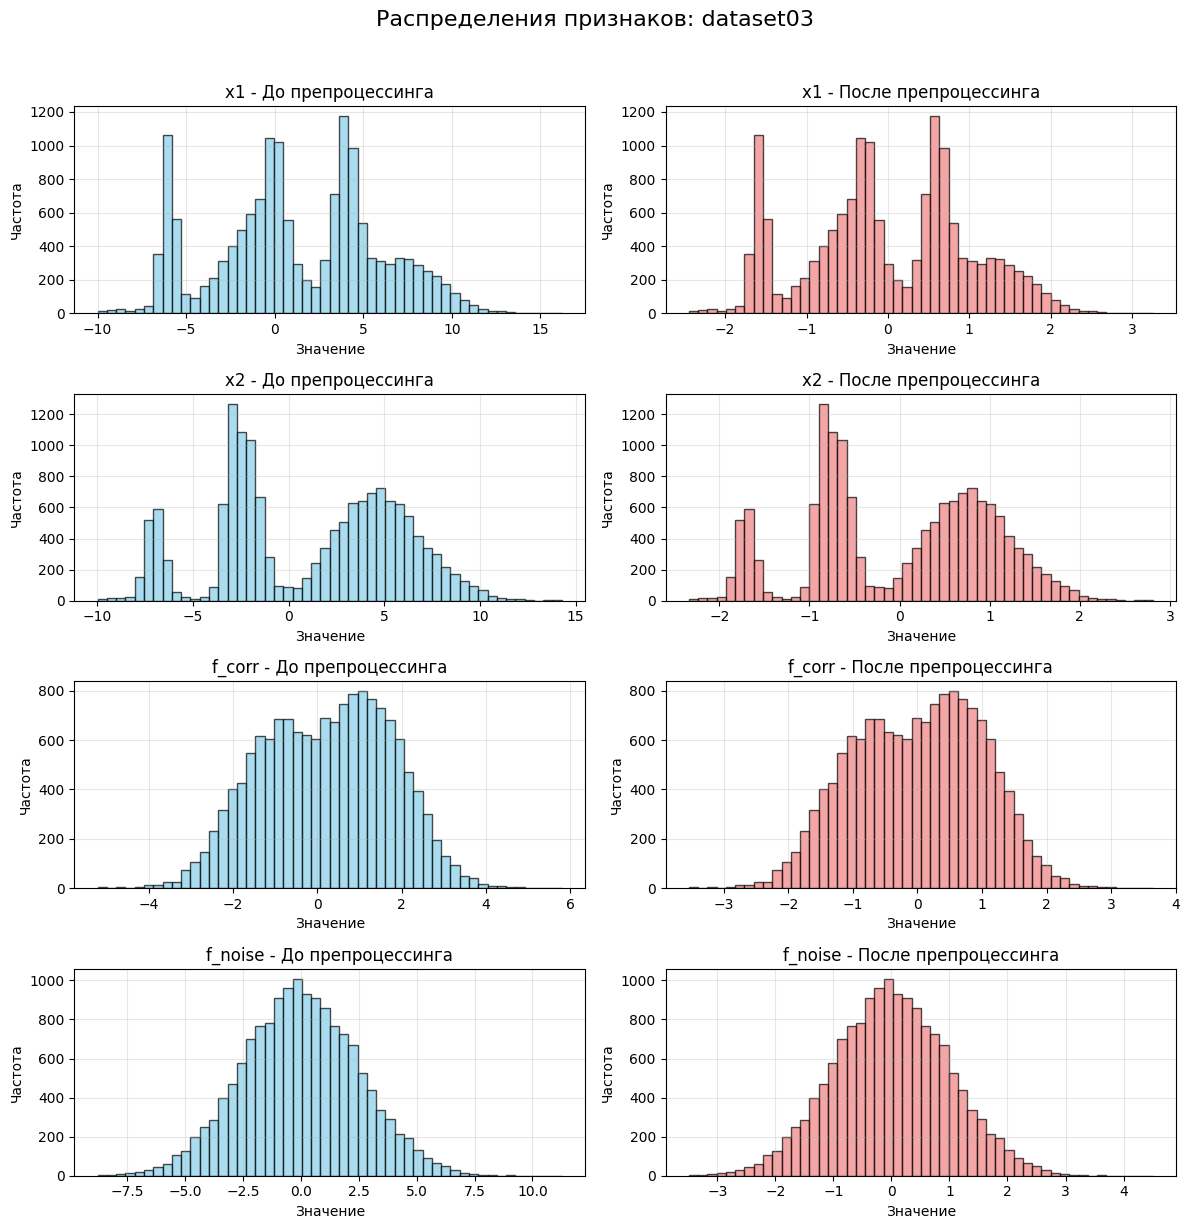

Сохранено: artifacts\figures\dataset03_distributions.png


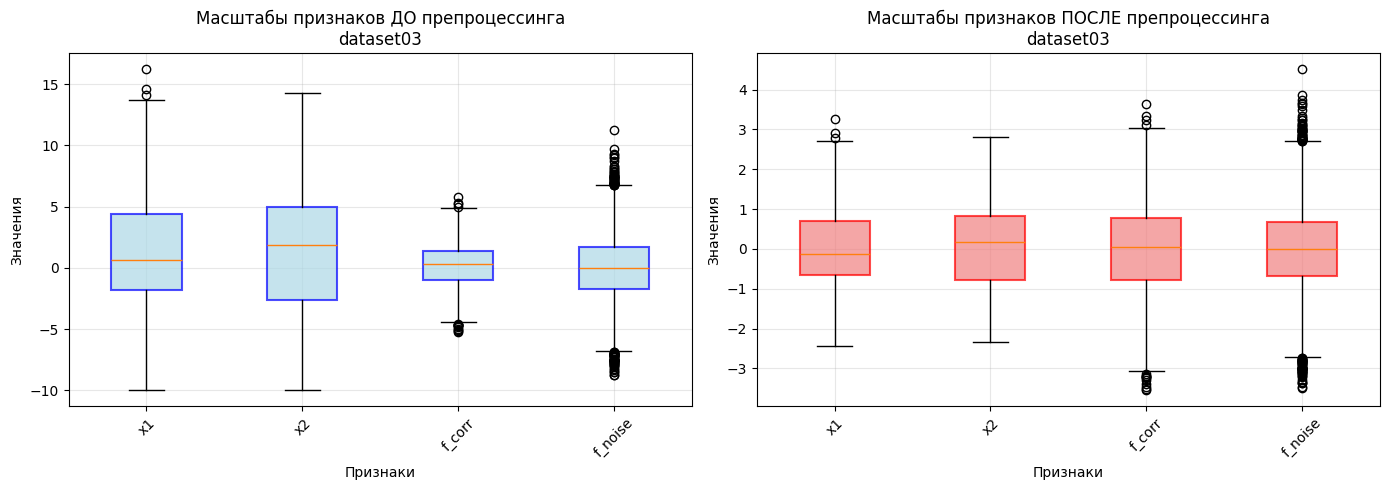

Сохранено: artifacts\figures\dataset03_scales_comparison.png


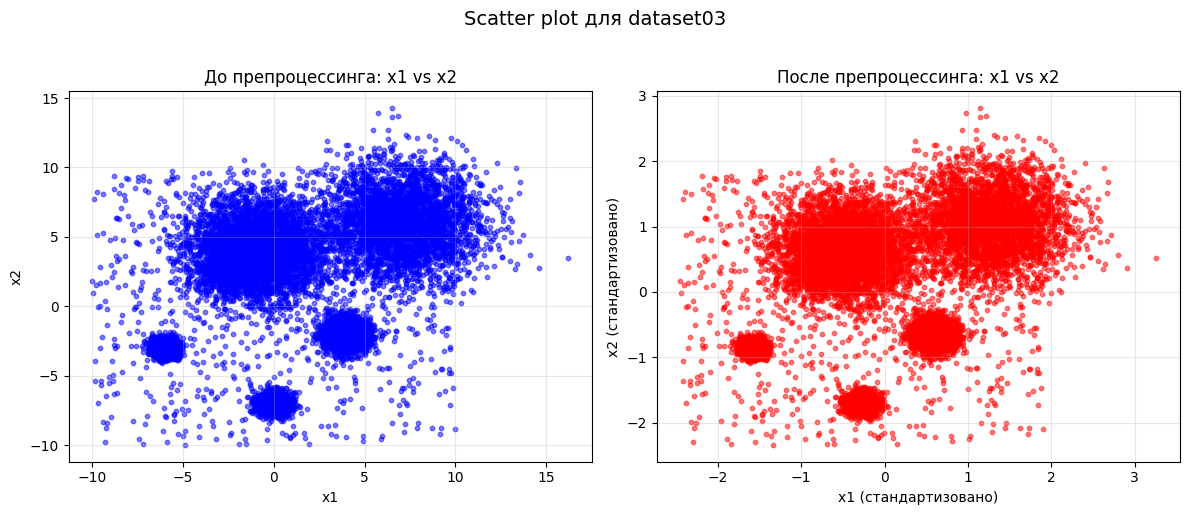

Сохранено: artifacts\figures\dataset03_scatter_comparison.png

Статистика для dataset03:
----------------------------------------
x1:
  До: mean=1.25, std=4.59
  После: mean=0.00, std=1.00

x2:
  До: mean=1.03, std=4.71
  После: mean=0.00, std=1.00

f_corr:
  До: mean=0.21, std=1.53
  После: mean=0.00, std=1.00



In [55]:
save_preprocessing_plots(df1, X1_processed, "dataset01", features01)
save_preprocessing_plots(df2, X2_processed, "dataset02", features02)
save_preprocessing_plots(df3, X3_processed, "dataset03", features03)

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

def evaluate_kmeans(X, dataset_name, max_k=15, random_state=42):
    
    print(f"\n=== KMeans для {dataset_name} ===")
    
    k_values = range(2, max_k + 1)
    metrics = {'k': [], 'inertia': [], 'silhouette': [], 
               'calinski_harabasz': [], 'davies_bouldin': []}
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = kmeans.fit_predict(X)
        
        metrics['k'].append(k)
        metrics['inertia'].append(kmeans.inertia_)
        
        if len(np.unique(labels)) > 1:
            metrics['silhouette'].append(silhouette_score(X, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))
        else:
            metrics['silhouette'].append(np.nan)
            metrics['calinski_harabasz'].append(np.nan)
            metrics['davies_bouldin'].append(np.nan)
    
    # Находим оптимальное K по silhouette
    valid_silhouette = [s for s in metrics['silhouette'] if not np.isnan(s)]
    if valid_silhouette:
        best_idx = np.nanargmax(metrics['silhouette'])
        best_k = metrics['k'][best_idx]
        
        print(f"Оптимальное K по silhouette: {best_k}")
        print(f"Silhouette score: {metrics['silhouette'][best_idx]:.4f}")
        print(f"Calinski-Harabasz: {metrics['calinski_harabasz'][best_idx]:.4f}")
        print(f"Davies-Bouldin: {metrics['davies_bouldin'][best_idx]:.4f}")
        
        return metrics, best_k
    else:
        print("Не удалось вычислить метрики")
        return metrics, 3

# Применяем KMeans ко всем датасетам
kmeans_results = {}
best_ks = {}

# Dataset 01
kmeans_metrics_01, best_k_01 = evaluate_kmeans(X1_processed, "dataset01", max_k=15)
kmeans_results['dataset01'] = kmeans_metrics_01
best_ks['dataset01'] = best_k_01

# Dataset 02
kmeans_metrics_02, best_k_02 = evaluate_kmeans(X2_processed, "dataset02", max_k=10)
kmeans_results['dataset02'] = kmeans_metrics_02
best_ks['dataset02'] = best_k_02

# Dataset 03
kmeans_metrics_03, best_k_03 = evaluate_kmeans(X3_processed, "dataset03", max_k=10)
kmeans_results['dataset03'] = kmeans_metrics_03
best_ks['dataset03'] = best_k_03


=== KMeans для dataset01 ===
Оптимальное K по silhouette: 2
Silhouette score: 0.5216
Calinski-Harabasz: 11786.9546
Davies-Bouldin: 0.6853

=== KMeans для dataset02 ===
Оптимальное K по silhouette: 2
Silhouette score: 0.3069
Calinski-Harabasz: 3573.3933
Davies-Bouldin: 1.3235

=== KMeans для dataset03 ===
Оптимальное K по silhouette: 3
Silhouette score: 0.3155
Calinski-Harabasz: 6957.1626
Davies-Bouldin: 1.1577


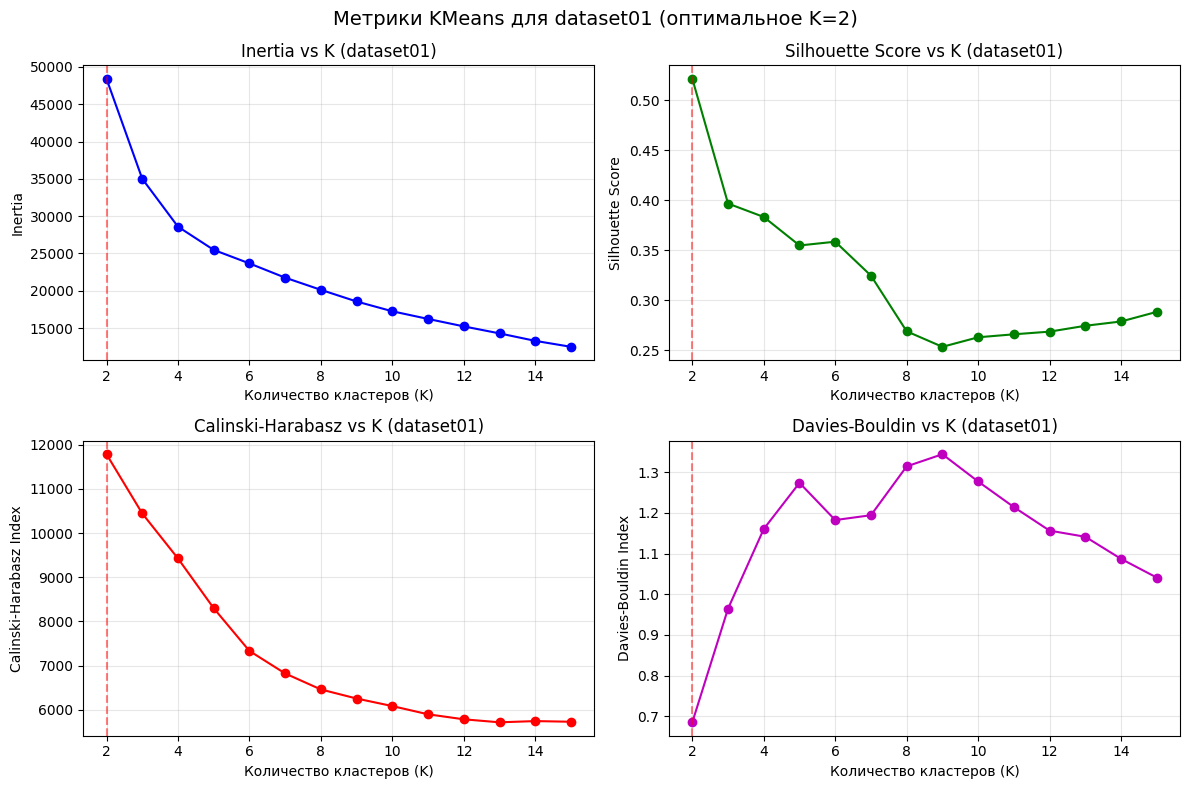

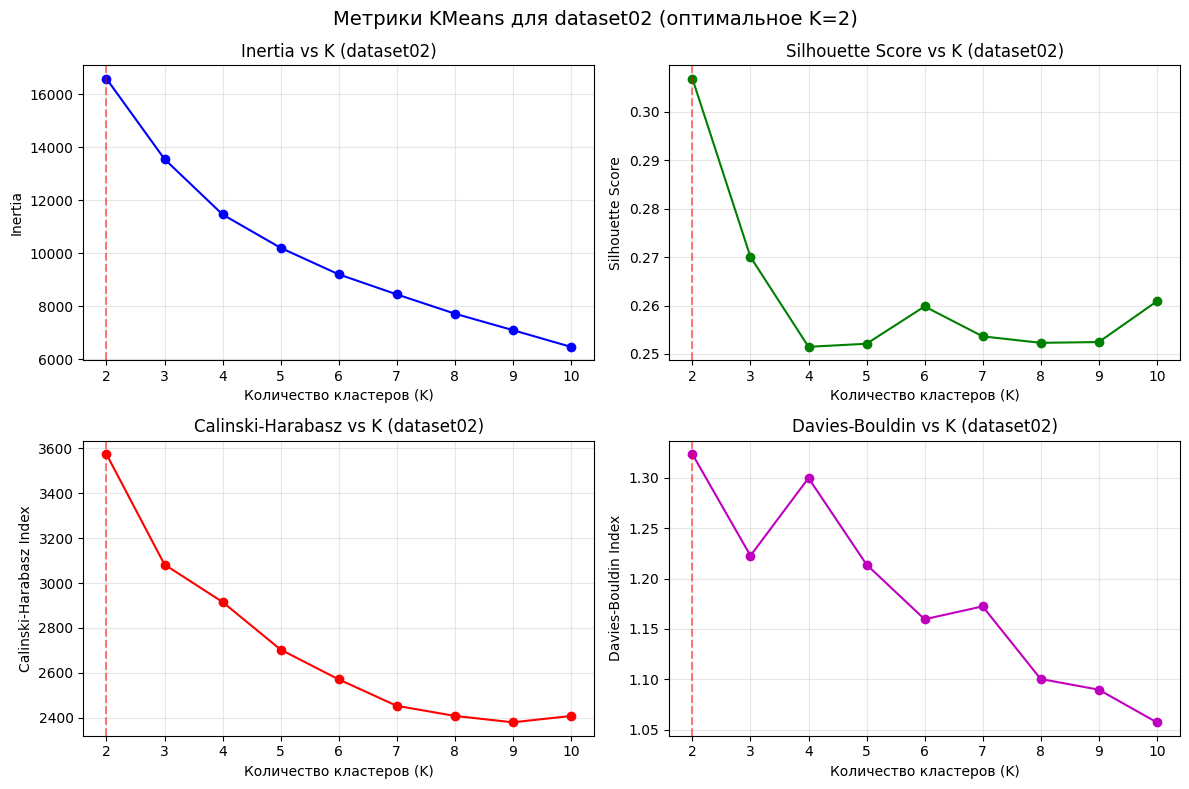

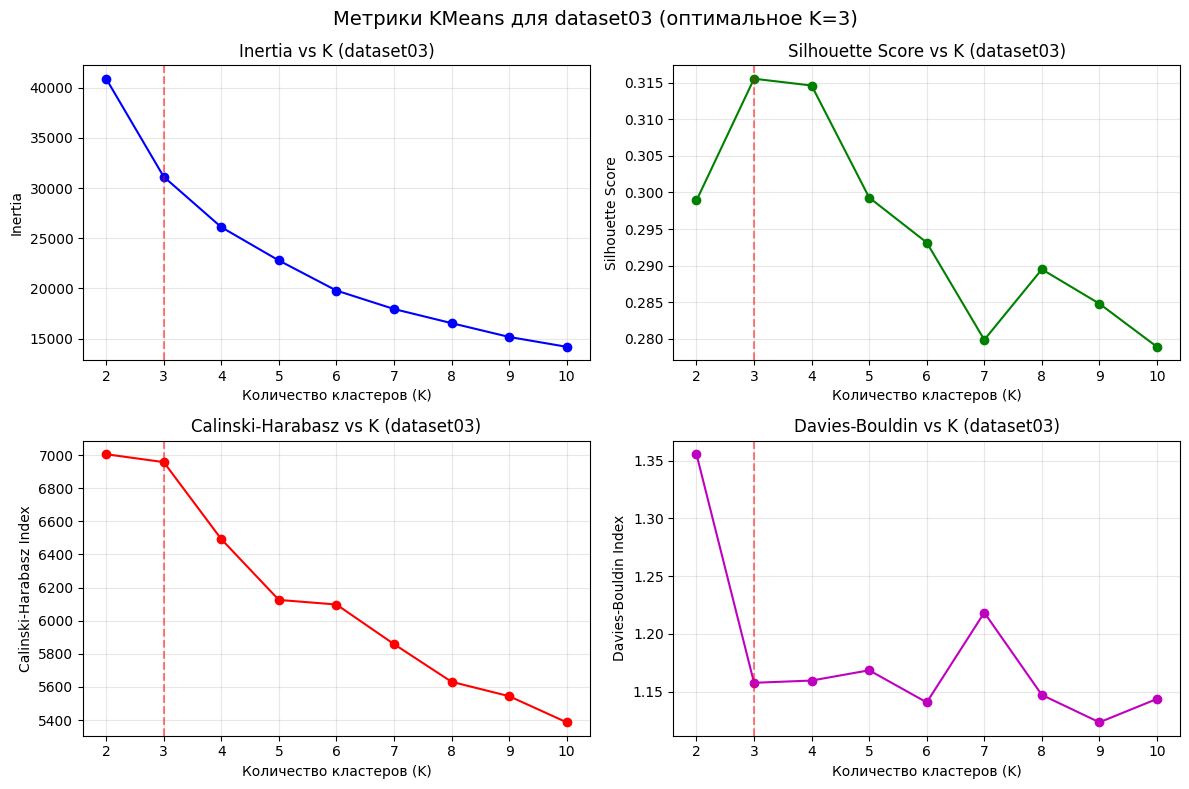

In [57]:
import matplotlib.pyplot as plt

def plot_kmeans_metrics(metrics, dataset_name, best_k, save_path=None):
    """
    Визуализация метрик KMeans
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Inertia (метод локтя)
    axes[0, 0].plot(metrics['k'], metrics['inertia'], 'bo-')
    axes[0, 0].axvline(x=best_k, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_title(f'Inertia vs K ({dataset_name})')
    axes[0, 0].set_xlabel('Количество кластеров (K)')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Silhouette score
    axes[0, 1].plot(metrics['k'], metrics['silhouette'], 'go-')
    axes[0, 1].axvline(x=best_k, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_title(f'Silhouette Score vs K ({dataset_name})')
    axes[0, 1].set_xlabel('Количество кластеров (K)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Calinski-Harabasz
    axes[1, 0].plot(metrics['k'], metrics['calinski_harabasz'], 'ro-')
    axes[1, 0].axvline(x=best_k, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_title(f'Calinski-Harabasz vs K ({dataset_name})')
    axes[1, 0].set_xlabel('Количество кластеров (K)')
    axes[1, 0].set_ylabel('Calinski-Harabasz Index')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Davies-Bouldin
    axes[1, 1].plot(metrics['k'], metrics['davies_bouldin'], 'mo-')
    axes[1, 1].axvline(x=best_k, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_title(f'Davies-Bouldin vs K ({dataset_name})')
    axes[1, 1].set_xlabel('Количество кластеров (K)')
    axes[1, 1].set_ylabel('Davies-Bouldin Index')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Метрики KMeans для {dataset_name} (оптимальное K={best_k})', fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Визуализируем для каждого датасета
plot_kmeans_metrics(kmeans_metrics_01, "dataset01", best_k_01, figures_dir / "kmeans_metrics_01.png")
plot_kmeans_metrics(kmeans_metrics_02, "dataset02", best_k_02, figures_dir / "kmeans_metrics_02.png")
plot_kmeans_metrics(kmeans_metrics_03, "dataset03", best_k_03, figures_dir / "kmeans_metrics_03.png")

In [58]:
def find_optimal_eps(X, k=4):
    
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    
    distances = np.sort(distances[:, k-1])
    
    # Поиск точки наибольшего изгиба
    derivatives = np.diff(distances)
    if len(derivatives) > 0:
        elbow_index = np.argmax(derivatives)
        optimal_eps = distances[elbow_index]
    else:
        optimal_eps = 0.5
    
    return distances, optimal_eps

def evaluate_dbscan(X, dataset_name):
    
    print(f"\n=== DBSCAN для {dataset_name} ===")
    
    # Находим оптимальный eps
    distances, optimal_eps = find_optimal_eps(X, k=4)
    
    print(f"Оптимальный eps (метод 4-го соседа): {optimal_eps:.4f}")
    
    # Тестируем разные параметры
    eps_values = [optimal_eps * 0.5, optimal_eps, optimal_eps * 1.5]
    min_samples_values = [5, 10, 15]
    
    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Статистика по кластерам
            unique_labels = np.unique(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            n_noise = np.sum(labels == -1)
            noise_ratio = n_noise / len(labels)
            
            # Метрики (без шума)
            mask = labels != -1
            if n_clusters >= 2 and np.sum(mask) > 0:
                X_filtered = X[mask]
                labels_filtered = labels[mask]
                
                silhouette = silhouette_score(X_filtered, labels_filtered)
                calinski = calinski_harabasz_score(X_filtered, labels_filtered)
                davies = davies_bouldin_score(X_filtered, labels_filtered)
            else:
                silhouette = np.nan
                calinski = np.nan
                davies = np.nan
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': noise_ratio,
                'silhouette': silhouette,
                'calinski_harabasz': calinski,
                'davies_bouldin': davies,
                'labels': labels
            })
    
    # Выбираем лучшую конфигурацию по silhouette
    valid_results = [r for r in results if not np.isnan(r['silhouette'])]
    if valid_results:
        best_result = max(valid_results, key=lambda x: x['silhouette'])
        
        print(f"Лучшие параметры: eps={best_result['eps']:.4f}, min_samples={best_result['min_samples']}")
        print(f"Кластеров: {best_result['n_clusters']}, Шума: {best_result['n_noise']} ({best_result['noise_ratio']:.1%})")
        print(f"Silhouette: {best_result['silhouette']:.4f}")
        print(f"Calinski-Harabasz: {best_result['calinski_harabasz']:.4f}")
        print(f"Davies-Bouldin: {best_result['davies_bouldin']:.4f}")
        
        return results, best_result, distances, optimal_eps
    else:
        print("Не удалось найти валидные кластеры")
        return results, None, distances, optimal_eps

# Применяем DBSCAN ко всем датасетам
dbscan_results = {}
dbscan_best = {}

# Dataset 01
dbscan_res_01, best_01, dist_01, eps_01 = evaluate_dbscan(X1_processed, "dataset01")
dbscan_results['dataset01'] = dbscan_res_01
dbscan_best['dataset01'] = best_01

# Dataset 02
dbscan_res_02, best_02, dist_02, eps_02 = evaluate_dbscan(X2_processed, "dataset02")
dbscan_results['dataset02'] = dbscan_res_02
dbscan_best['dataset02'] = best_02

# Dataset 03
dbscan_res_03, best_03, dist_03, eps_03 = evaluate_dbscan(X3_processed, "dataset03")
dbscan_results['dataset03'] = dbscan_res_03
dbscan_best['dataset03'] = best_03


=== DBSCAN для dataset01 ===
Оптимальный eps (метод 4-го соседа): 1.1853
Лучшие параметры: eps=1.7779, min_samples=5
Кластеров: 2, Шума: 0 (0.0%)
Silhouette: 0.5216
Calinski-Harabasz: 11786.9546
Davies-Bouldin: 0.6853

=== DBSCAN для dataset02 ===
Оптимальный eps (метод 4-го соседа): 1.3717
Лучшие параметры: eps=0.6859, min_samples=10
Кластеров: 5, Шума: 318 (4.0%)
Silhouette: 0.3321
Calinski-Harabasz: 144.6080
Davies-Bouldin: 0.6271

=== DBSCAN для dataset03 ===
Оптимальный eps (метод 4-го соседа): 1.4950
Не удалось найти валидные кластеры


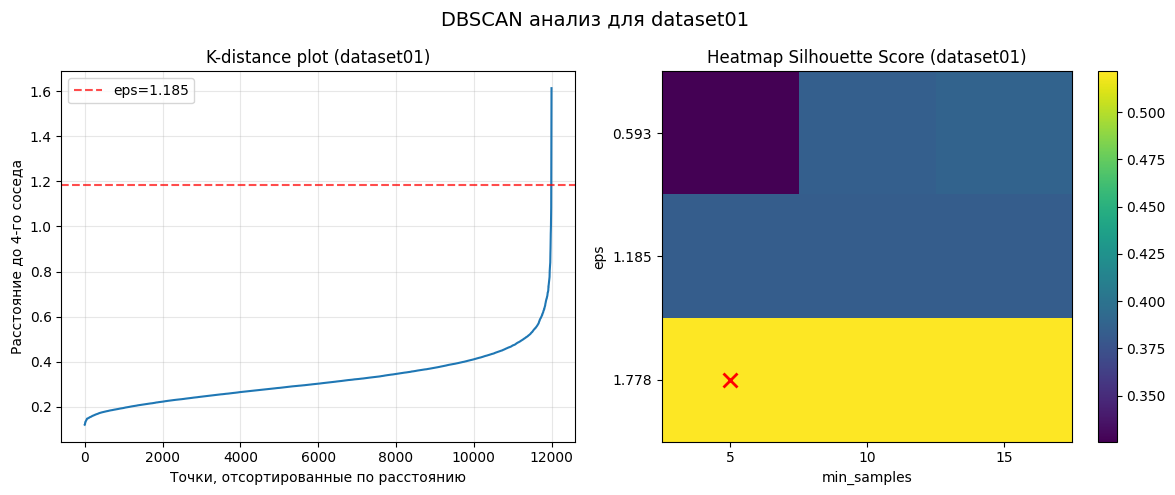

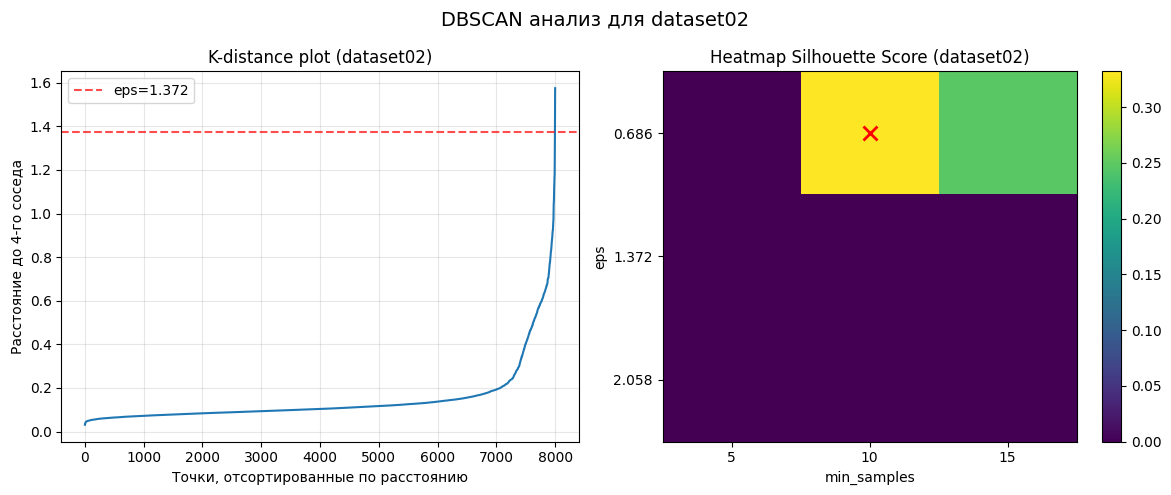

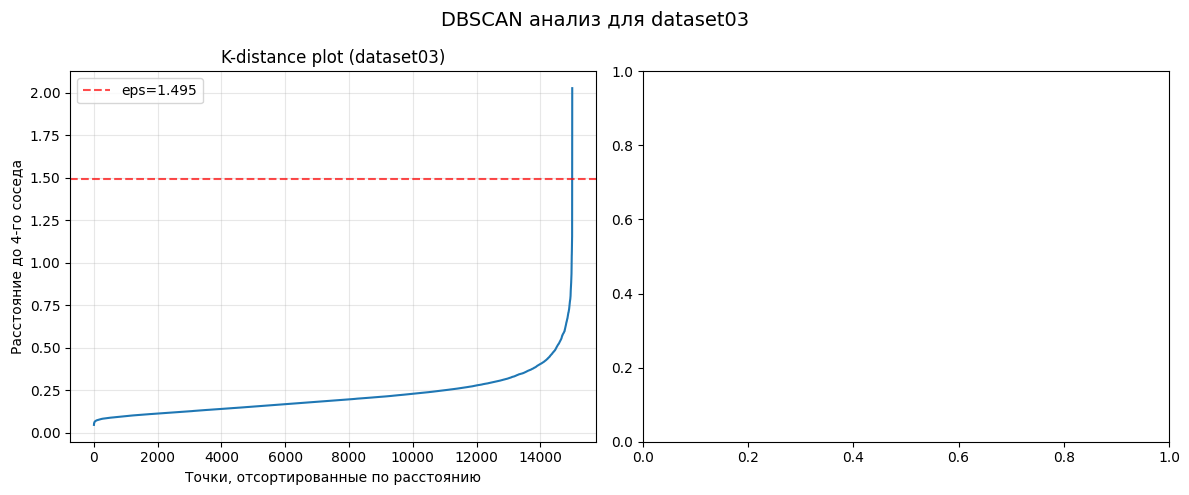

In [59]:
def plot_dbscan_results(distances, optimal_eps, dataset_name, best_result, save_path=None):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # K-distance plot
    axes[0].plot(np.sort(distances))
    axes[0].axhline(y=optimal_eps, color='r', linestyle='--', alpha=0.7, 
                    label=f'eps={optimal_eps:.3f}')
    axes[0].set_title(f'K-distance plot ({dataset_name})')
    axes[0].set_xlabel('Точки, отсортированные по расстоянию')
    axes[0].set_ylabel('Расстояние до 4-го соседа')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Heatmap параметров
    if best_result:
        eps_values = sorted(set(r['eps'] for r in dbscan_results[dataset_name]))
        min_samples_values = sorted(set(r['min_samples'] for r in dbscan_results[dataset_name]))
        
        silhouette_matrix = np.zeros((len(eps_values), len(min_samples_values)))
        
        for r in dbscan_results[dataset_name]:
            eps_idx = eps_values.index(r['eps'])
            ms_idx = min_samples_values.index(r['min_samples'])
            silhouette_matrix[eps_idx, ms_idx] = r['silhouette'] if not np.isnan(r['silhouette']) else 0
        
        im = axes[1].imshow(silhouette_matrix, cmap='viridis', aspect='auto')
        axes[1].set_title(f'Heatmap Silhouette Score ({dataset_name})')
        axes[1].set_xlabel('min_samples')
        axes[1].set_ylabel('eps')
        axes[1].set_xticks(range(len(min_samples_values)))
        axes[1].set_yticks(range(len(eps_values)))
        axes[1].set_xticklabels(min_samples_values)
        axes[1].set_yticklabels([f'{eps:.3f}' for eps in eps_values])
        
        # Отмечаем лучшие параметры
        best_eps_idx = eps_values.index(best_result['eps'])
        best_ms_idx = min_samples_values.index(best_result['min_samples'])
        axes[1].plot(best_ms_idx, best_eps_idx, 'rx', markersize=10, markeredgewidth=2)
        
        plt.colorbar(im, ax=axes[1])
    
    plt.suptitle(f'DBSCAN анализ для {dataset_name}', fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Визуализируем для каждого датасета
plot_dbscan_results(dist_01, eps_01, "dataset01", best_01, figures_dir / "dbscan_analysis_01.png")
plot_dbscan_results(dist_02, eps_02, "dataset02", best_02, figures_dir / "dbscan_analysis_02.png")
plot_dbscan_results(dist_03, eps_03, "dataset03", best_03, figures_dir / "dbscan_analysis_03.png")

C:\Users\Lenovo-PC\AppData\Local\Temp\ipykernel_20168\863387208.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


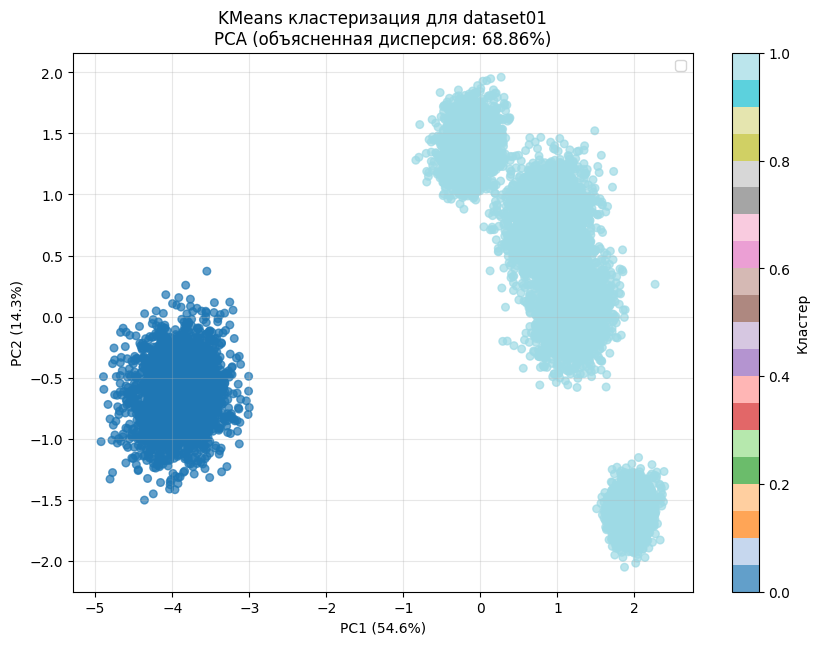

C:\Users\Lenovo-PC\AppData\Local\Temp\ipykernel_20168\863387208.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


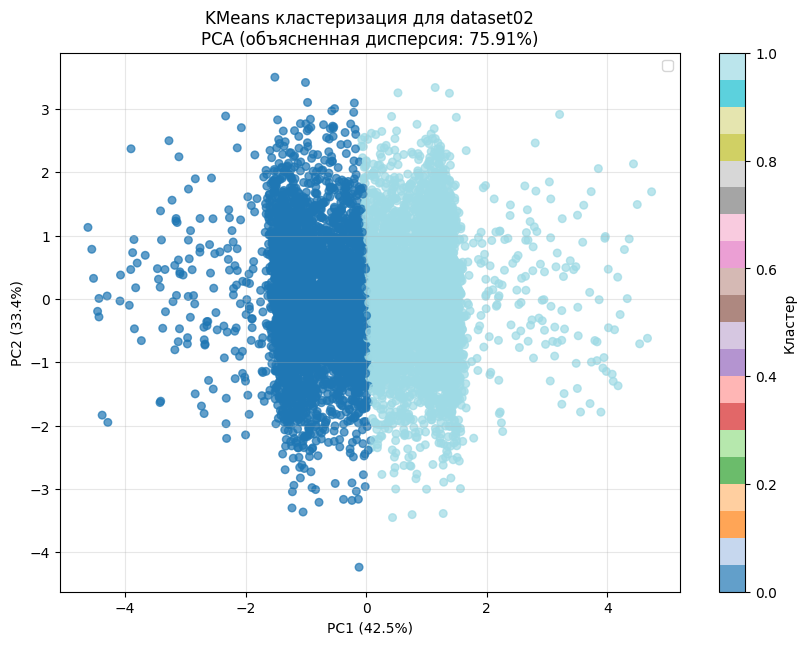

C:\Users\Lenovo-PC\AppData\Local\Temp\ipykernel_20168\863387208.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


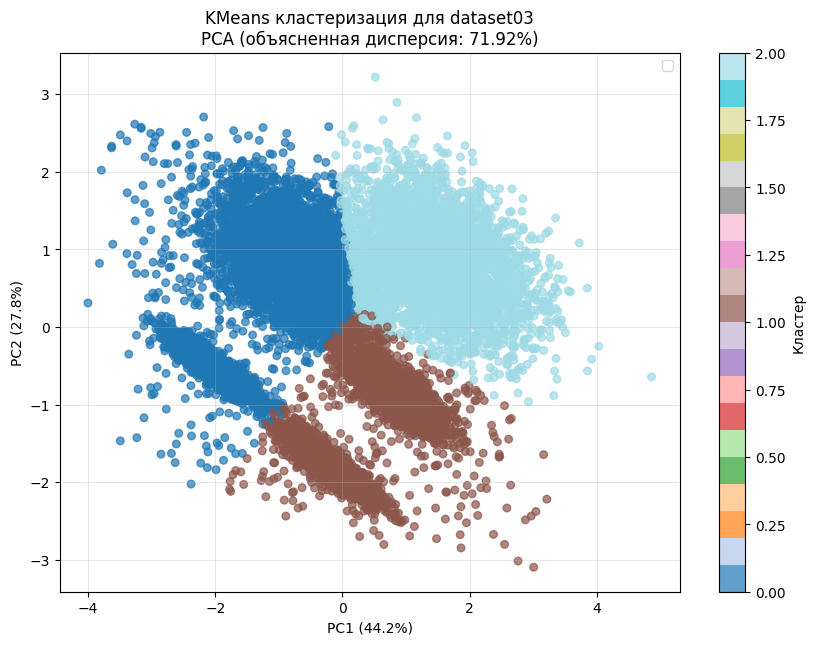

C:\Users\Lenovo-PC\AppData\Local\Temp\ipykernel_20168\863387208.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


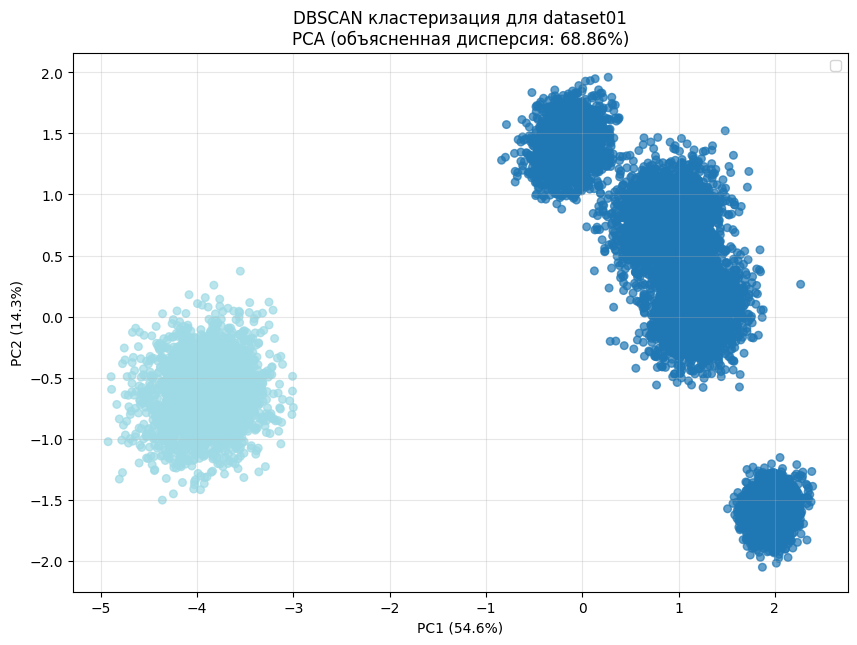

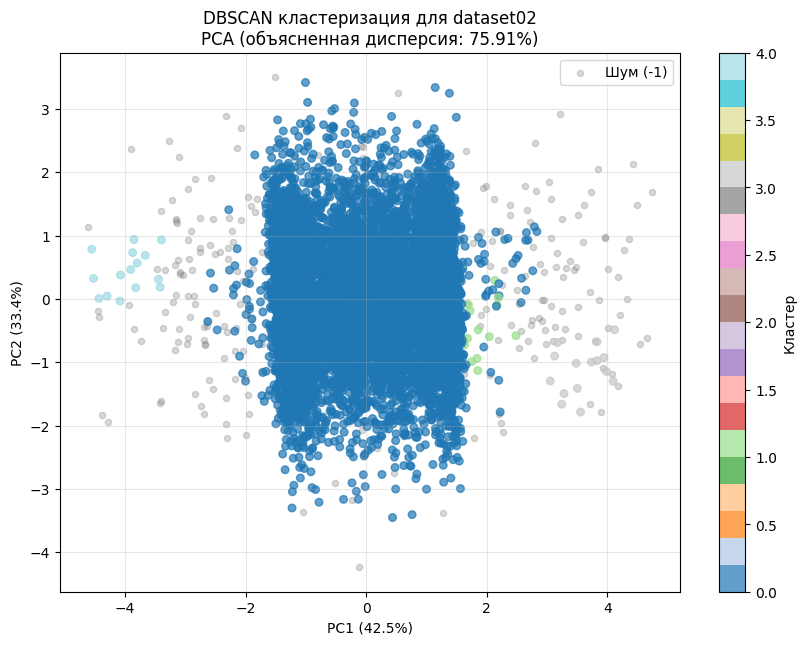

In [60]:
from sklearn.decomposition import PCA

def plot_pca_clusters(X, labels, dataset_name, algorithm, save_path=None):
    
    # Применяем PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 7))
    
    # Для DBSCAN отдельно выделяем шум
    if algorithm == "DBSCAN" and -1 in labels:
        # Шум
        noise_mask = labels == -1
        plt.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
                   c='gray', s=20, alpha=0.3, label='Шум (-1)')
        
        # Кластеры
        cluster_mask = labels != -1
        scatter = plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
                             c=labels[cluster_mask], cmap='tab20', s=30, alpha=0.7)
    else:
        # Для KMeans и других алгоритмов
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=labels, cmap='tab20', s=30, alpha=0.7)
    
    plt.title(f'{algorithm} кластеризация для {dataset_name}\n'
              f'PCA (объясненная дисперсия: {np.sum(pca.explained_variance_ratio_):.2%})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    
    if algorithm != "DBSCAN" or (-1 in labels):
        plt.colorbar(scatter, label='Кластер')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Создаем лучшие модели KMeans
best_models = {}

for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    best_k = best_ks[dataset_name]
    X = preprocessing_results[dataset_name]['X_processed']
    
    kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    labels_kmeans = kmeans.fit_predict(X)
    best_models[f'{dataset_name}_kmeans'] = {'model': kmeans, 'labels': labels_kmeans}
    
    # PCA визуализация KMeans
    plot_pca_clusters(X, labels_kmeans, dataset_name, "KMeans", 
                     figures_dir / f"pca_kmeans_{dataset_name}.png")

# PCA визуализация лучших DBSCAN (если есть)
for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    if dbscan_best[dataset_name]:
        X = preprocessing_results[dataset_name]['X_processed']
        labels_dbscan = dbscan_best[dataset_name]['labels']
        
        plot_pca_clusters(X, labels_dbscan, dataset_name, "DBSCAN", 
                         figures_dir / f"pca_dbscan_{dataset_name}.png")

In [61]:
def compare_algorithms(kmeans_metrics, dbscan_best, best_k, dataset_name):
    
    print(f"\n=== Сравнение алгоритмов для {dataset_name} ===")
    
    # Метрики KMeans с оптимальным K
    kmeans_idx = kmeans_metrics['k'].index(best_k)
    kmeans_sil = kmeans_metrics['silhouette'][kmeans_idx]
    kmeans_ch = kmeans_metrics['calinski_harabasz'][kmeans_idx]
    kmeans_db = kmeans_metrics['davies_bouldin'][kmeans_idx]
    
    print(f"KMeans (K={best_k}):")
    print(f"  Silhouette: {kmeans_sil:.4f}")
    print(f"  Calinski-Harabasz: {kmeans_ch:.4f}")
    print(f"  Davies-Bouldin: {kmeans_db:.4f}")
    
    if dbscan_best:
        print(f"\nDBSCAN (eps={dbscan_best['eps']:.3f}, min_samples={dbscan_best['min_samples']}):")
        print(f"  Silhouette: {dbscan_best['silhouette']:.4f}")
        print(f"  Calinski-Harabasz: {dbscan_best['calinski_harabasz']:.4f}")
        print(f"  Davies-Bouldin: {dbscan_best['davies_bouldin']:.4f}")
        print(f"  Кластеров: {dbscan_best['n_clusters']}")
        print(f"  Доля шума: {dbscan_best['noise_ratio']:.1%}")
    
    # Выбор лучшего алгоритма
    if dbscan_best and not np.isnan(dbscan_best['silhouette']):
        if dbscan_best['silhouette'] > kmeans_sil:
            print(f"\nЛучший алгоритм: DBSCAN (лучший silhouette)")
            return "DBSCAN", dbscan_best
        else:
            print(f"\nЛучший алгоритм: KMeans (лучший silhouette)")
            return "KMeans", {'silhouette': kmeans_sil, 'calinski_harabasz': kmeans_ch, 
                             'davies_bouldin': kmeans_db, 'k': best_k}
    else:
        print(f"\nЛучший алгоритм: KMeans (единственный валидный)")
        return "KMeans", {'silhouette': kmeans_sil, 'calinski_harabasz': kmeans_ch, 
                         'davies_bouldin': kmeans_db, 'k': best_k}

# Сравниваем для всех датасетов
best_algorithms = {}
best_metrics = {}

for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    best_algo, metrics = compare_algorithms(
        kmeans_results[dataset_name], 
        dbscan_best[dataset_name], 
        best_ks[dataset_name],
        dataset_name
    )
    best_algorithms[dataset_name] = best_algo
    best_metrics[dataset_name] = metrics

# Создаем сводную таблицу
summary_data = []
for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    row = {'Dataset': dataset_name}
    
    # KMeans метрики
    kmeans_idx = kmeans_results[dataset_name]['k'].index(best_ks[dataset_name])
    row['KMeans_Silhouette'] = kmeans_results[dataset_name]['silhouette'][kmeans_idx]
    row['KMeans_CH'] = kmeans_results[dataset_name]['calinski_harabasz'][kmeans_idx]
    row['KMeans_DB'] = kmeans_results[dataset_name]['davies_bouldin'][kmeans_idx]
    row['KMeans_K'] = best_ks[dataset_name]
    
    # DBSCAN метрики
    if dbscan_best[dataset_name]:
        row['DBSCAN_Silhouette'] = dbscan_best[dataset_name]['silhouette']
        row['DBSCAN_CH'] = dbscan_best[dataset_name]['calinski_harabasz']
        row['DBSCAN_DB'] = dbscan_best[dataset_name]['davies_bouldin']
        row['DBSCAN_Clusters'] = dbscan_best[dataset_name]['n_clusters']
        row['DBSCAN_Noise_Ratio'] = dbscan_best[dataset_name]['noise_ratio']
    else:
        row['DBSCAN_Silhouette'] = np.nan
        row['DBSCAN_CH'] = np.nan
        row['DBSCAN_DB'] = np.nan
        row['DBSCAN_Clusters'] = 0
        row['DBSCAN_Noise_Ratio'] = 0.0
    
    row['Best_Algorithm'] = best_algorithms[dataset_name]
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА МЕТРИК")
print("="*60)
print(summary_df.to_string(index=False))


=== Сравнение алгоритмов для dataset01 ===
KMeans (K=2):
  Silhouette: 0.5216
  Calinski-Harabasz: 11786.9546
  Davies-Bouldin: 0.6853

DBSCAN (eps=1.778, min_samples=5):
  Silhouette: 0.5216
  Calinski-Harabasz: 11786.9546
  Davies-Bouldin: 0.6853
  Кластеров: 2
  Доля шума: 0.0%

Лучший алгоритм: KMeans (лучший silhouette)

=== Сравнение алгоритмов для dataset02 ===
KMeans (K=2):
  Silhouette: 0.3069
  Calinski-Harabasz: 3573.3933
  Davies-Bouldin: 1.3235

DBSCAN (eps=0.686, min_samples=10):
  Silhouette: 0.3321
  Calinski-Harabasz: 144.6080
  Davies-Bouldin: 0.6271
  Кластеров: 5
  Доля шума: 4.0%

Лучший алгоритм: DBSCAN (лучший silhouette)

=== Сравнение алгоритмов для dataset03 ===
KMeans (K=3):
  Silhouette: 0.3155
  Calinski-Harabasz: 6957.1626
  Davies-Bouldin: 1.1577

Лучший алгоритм: KMeans (единственный валидный)

СВОДНАЯ ТАБЛИЦА МЕТРИК
  Dataset  KMeans_Silhouette    KMeans_CH  KMeans_DB  KMeans_K  DBSCAN_Silhouette    DBSCAN_CH  DBSCAN_DB  DBSCAN_Clusters  DBSCAN_Noise_R


=== Устойчивость KMeans (K=2, 5 запусков) ===
Запуск 1: inertia = 48425.91
Запуск 2: inertia = 48425.91
Запуск 3: inertia = 48425.91
Запуск 4: inertia = 48425.91
Запуск 5: inertia = 48425.91

Статистика ARI между запусками:
  Среднее ARI: 1.0000
  Стандартное отклонение: 0.0000
  Минимальное ARI: 1.0000
  Максимальное ARI: 1.0000


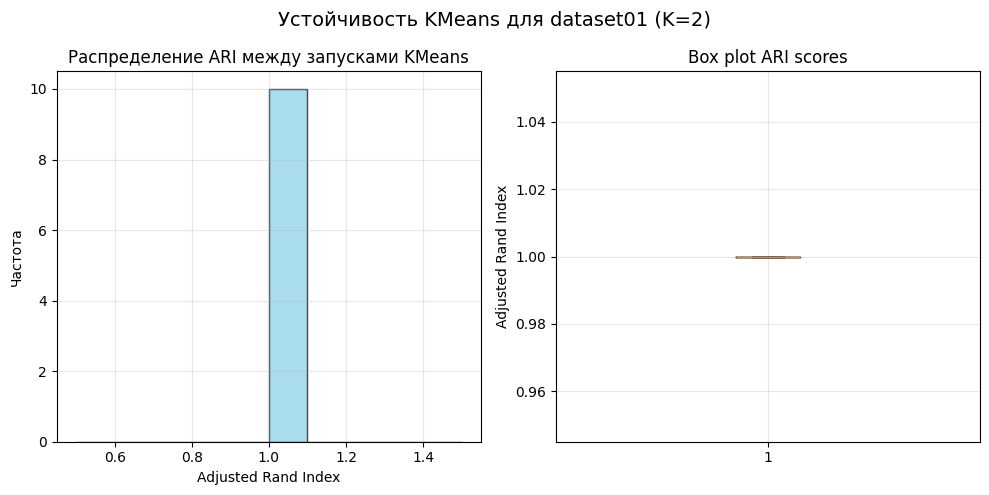

In [64]:
from sklearn.metrics import adjusted_rand_score

def evaluate_kmeans_stability(X, n_runs=5, k=4):
    
    print(f"\n=== Устойчивость KMeans (K={k}, {n_runs} запусков) ===")
    
    all_labels = []
    
    for i in range(n_runs):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=i*10)  # Разные random_state
        labels = kmeans.fit_predict(X)
        all_labels.append(labels)
        
        print(f"Запуск {i+1}: inertia = {kmeans.inertia_:.2f}")
    
    # Вычисляем попарное сходство (ARI)
    ari_scores = []
    for i in range(n_runs):
        for j in range(i+1, n_runs):
            ari = adjusted_rand_score(all_labels[i], all_labels[j])
            ari_scores.append(ari)
    
    print(f"\nСтатистика ARI между запусками:")
    print(f"  Среднее ARI: {np.mean(ari_scores):.4f}")
    print(f"  Стандартное отклонение: {np.std(ari_scores):.4f}")
    print(f"  Минимальное ARI: {np.min(ari_scores):.4f}")
    print(f"  Максимальное ARI: {np.max(ari_scores):.4f}")
    
    return all_labels, ari_scores

# Оцениваем устойчивость для dataset01 с оптимальным K
stability_labels, ari_scores = evaluate_kmeans_stability(
    X1_processed, 
    n_runs=5, 
    k=best_ks['dataset01']
)

# Визуализация устойчивости
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(ari_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение ARI между запусками KMeans')
plt.xlabel('Adjusted Rand Index')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(ari_scores)
plt.title('Box plot ARI scores')
plt.ylabel('Adjusted Rand Index')
plt.grid(True, alpha=0.3)

plt.suptitle(f'Устойчивость KMeans для dataset01 (K={best_ks["dataset01"]})', fontsize=14)
plt.tight_layout()
plt.savefig(figures_dir / "kmeans_stability.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import json
import pandas as pd
from pathlib import Path


artifacts_dir = Path("artifacts")
labels_dir = artifacts_dir / "labels"
labels_dir.mkdir(exist_ok=True)

# 1. Сохраняем сводку метрик
metrics_summary = {}

for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    metrics_summary[dataset_name] = {
        'KMeans': {
            'k': int(best_ks[dataset_name]),
            'silhouette': float(kmeans_results[dataset_name]['silhouette'][
                kmeans_results[dataset_name]['k'].index(best_ks[dataset_name])
            ]),
            'calinski_harabasz': float(kmeans_results[dataset_name]['calinski_harabasz'][
                kmeans_results[dataset_name]['k'].index(best_ks[dataset_name])
            ]),
            'davies_bouldin': float(kmeans_results[dataset_name]['davies_bouldin'][
                kmeans_results[dataset_name]['k'].index(best_ks[dataset_name])
            ])
        },
        'DBSCAN': {},
        'best_algorithm': best_algorithms[dataset_name]
    }
    
    if dbscan_best[dataset_name]:
        metrics_summary[dataset_name]['DBSCAN'] = {
            'eps': float(dbscan_best[dataset_name]['eps']),
            'min_samples': int(dbscan_best[dataset_name]['min_samples']),
            'n_clusters': int(dbscan_best[dataset_name]['n_clusters']),
            'n_noise': int(dbscan_best[dataset_name]['n_noise']),
            'noise_ratio': float(dbscan_best[dataset_name]['noise_ratio']),
            'silhouette': float(dbscan_best[dataset_name]['silhouette']),
            'calinski_harabasz': float(dbscan_best[dataset_name]['calinski_harabasz']),
            'davies_bouldin': float(dbscan_best[dataset_name]['davies_bouldin'])
        }

with open(artifacts_dir / "metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

print(f"metrics_summary.json сохранен")

# 2. Сохраняем лучшие конфигурации
best_configs = {}

for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    if best_algorithms[dataset_name] == 'KMeans':
        best_configs[dataset_name] = {
            'algorithm': 'KMeans',
            'parameters': {
                'n_clusters': int(best_ks[dataset_name]),
                'n_init': 10,
                'random_state': 42
            },
            'criterion': 'silhouette_score'
        }
    else:
        best_configs[dataset_name] = {
            'algorithm': 'DBSCAN',
            'parameters': {
                'eps': float(dbscan_best[dataset_name]['eps']),
                'min_samples': int(dbscan_best[dataset_name]['min_samples'])
            },
            'criterion': 'silhouette_score'
        }

with open(artifacts_dir / "best_configs.json", "w", encoding="utf-8") as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print(f"best_configs.json сохранен")

# 3. Сохраняем метки кластеров для лучших алгоритмов
for dataset_name in ['dataset01', 'dataset02', 'dataset03']:
    # Получаем исходный DataFrame
    if dataset_name == 'dataset01':
        df = df1
        X = X1_processed
    elif dataset_name == 'dataset02':
        df = df2
        X = X2_processed
    else:
        df = df3
        X = X3_processed
    
    # Получаем метки от лучшего алгоритма
    if best_algorithms[dataset_name] == 'KMeans':
        kmeans = KMeans(n_clusters=best_ks[dataset_name], n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)
    else:
        labels = dbscan_best[dataset_name]['labels']
    
    # Создаем DataFrame с метками
    labels_df = pd.DataFrame({
        'sample_id': df['sample_id'],
        'cluster_label': labels.astype(int)
    })
    
    # Сохраняем в CSV
    filename = labels_dir / f"labels_hw07_{dataset_name}.csv"
    labels_df.to_csv(filename, index=False)
    print(f"{filename} сохранен")

print("\n" + "="*60)
print("АРТЕФАКТЫ СОХРАНЕНЫ")
print("="*60)
print(f"1. metrics_summary.json - сводка метрик")
print(f"2. best_configs.json - лучшие конфигурации")
print(f"3. labels/ - файлы с метками кластеров")
print(f"4. figures/ - графики (уже сохранены ранее)")

metrics_summary.json сохранен
best_configs.json сохранен
artifacts\labels\labels_hw07_dataset01.csv сохранен
artifacts\labels\labels_hw07_dataset02.csv сохранен
artifacts\labels\labels_hw07_dataset03.csv сохранен

АРТЕФАКТЫ СОХРАНЕНЫ
1. metrics_summary.json - сводка метрик
2. best_configs.json - лучшие конфигурации
3. labels/ - файлы с метками кластеров
4. figures/ - графики (уже сохранены ранее)
